<a href="https://colab.research.google.com/github/Anaxitaxia/ObjectDetectionProject/blob/master/Mitrofanova_DetectionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=400, height=300></p>

<h3 align="center"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ </b></h3>

<h3 align="center"><b>Проект на тему</b></h3>

<h3 align="center"><b>OBJECT DETECTION</b></h3>

<p align="center"><i>выполнила: Митрофанова.А.Ю.</i></p>
<p align="center"><i>руководитель проекта: Илья Захаркин (Сколтех, ФИВТ МФТИ) | @ilyazakharkin</i></p>
<p align="center">январь-февраль, 2020г.</p>

# 1.  Введение
**Цель проекта:**
обучить модель детектировать лица на [датасете](http://shuoyang1213.me/WIDERFACE/)

**Задачи проекта:**


1.   Выбрать фреймворк и предобученную модель-детектор,
2.   запустить детектор на случайных изображениях,
3.   реализовать предобработку данных,
4.   обучить модель,
5.   измерить качество работы модели.

**Актуальность:**
Детектирование лиц может понадобиться для решения таких задач, как
1.   Обнаружение лиц, представляющих опасность, в общественных, многолюдных местах.

Так, например, внедрение моделей, способных детектировать лица, в сеть городских камер может помочь распознавать демонстрантов, протестующих, и других людей, нарущающих общественный порядок. Особенно полезна такая система будет во время праздников или крупных событий (как, например, чемпионат мира по футболу).

2.   Обнаружение опасных случаев (драки, демонстрации), чрезвычайных происшествий (автомобильная авария) и автоматическое уведомление соответствующих служб.
3.   Отбор и сортировка видео- и фото-материалов по заданной тематике.

Например, это может понадобится для создания новостных репортажей. Также это может помочь маркетологам выяснить, какого содержание рекламы для данного конкретного продукта, которая вызвала положительную реакцию у покупателей и увеличила прибыли.

4.   Присваивание хэштегов фотографиям в социальных сетях.

# 2. Установка библиотек

В качестве фреймворка был выбран *torchvision*. Его выбор был продиктован простотой использования в совокупности с маленьким опытом работы в сфере глубокого обучения.

Для того, чтобы обучить модель детектировать лица, было решено взять уже существующую, предобученную модель *Faster R-CNN* и применить к ней fine tuning.

**Основные используемые библиотеки и их назначение:**
1.   torch, sklearn --- библиотеки машинного обучения,
2.   numpy, предназначенная для вычислений с многомерными массивами,
3.   PIL и pathlib для работы с изображениями и обращения с системой файлов,
4.   cv2 --- библиотека, обеспечивающая работу с OpenCV,
5.   albumentations для применения аугментаций к изображениям и боксам.

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
import cv2

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

import albumentations.augmentations.functional as F
from albumentations.augmentations.transforms import RandomBrightnessContrast
import albumentations.augmentations.bbox_utils as box_utils

from sklearn.preprocessing import LabelEncoder

from PIL import Image, ImageDraw
from pathlib import Path

import pickle
import os

import scipy.io
import pandas as pd

from tqdm import tqdm, tqdm_notebook

%matplotlib inline

# 3.  Запуск детектора на случайных изображениях
В качестве пробных изображений, на которых можно проверить качество работы детектора, был взят [датасет](https://drive.google.com/open?id=19SI_dCEU808KZYmyZ2vBNEPUJCXHYmKB), составленный из десяти изображений. 

In [0]:
# импортируем содержимое google-диска
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
# распаковываем содержимое архива
!unzip -q /content/gdrive/My\ Drive/project_random_photos/for_detection.zip

In [0]:
DETECT_DIR = Path('for_detection')                      # название папки с изображениями
detect_files = sorted(list(DETECT_DIR.rglob('*.*')))    # список имён изображений типа PosixPath('DETECT_DIR/название_изображения.расширение')

In [0]:
np_images = []                                          # список изображений, переведённых в numpy.array
for detect_file in detect_files:
  im = cv2.imread(str(detect_file))[:,:,::-1]           # изображение типа numpy.array() с каналами RGB (cv2.imread перемешивает каналы)
  np_images.append(im)    

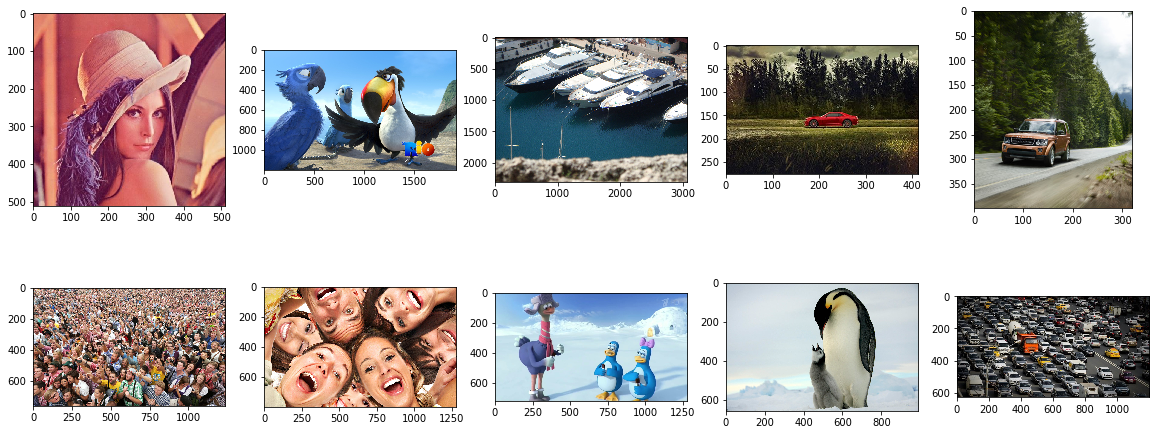

In [0]:
# выводим изображения на экран
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = np_images[i - 1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Пояним выбор изображений. Во-первых, планируется обучить модель детектировать лица, поэтому для начала интересно определить, насколько хорошо с этой задачей справляется существующая модель. Этим обусловлен выбор изображений людей. Также представляется интересным сравнить качество детектирования изображений с маленьким и большим количеством объектов (один человек/толпа, одна машина/скопление). Помимо этого стало интересно, как поведёт себя детектор на изображениях, с которыми он, явно, раньше не сталкивался (изобржения из мультфильма и рекламы).

In [0]:
# переводим модель в "рабочий" режим, т.е. ожидаем от неё предсказаний
model = model.eval().cuda()
tensor_images = []                              # спиок изображений, переведённых из типа numpy.array в тензор
for img in np_images:
  # модель ожидает на вход изображение размерностью [C, H, W], 
  # исходное изображение размерностями [H, W, C], поэтому применяем .permute()
  img = torch.from_numpy(img.astype('float32')).cuda().permute(2,0,1)
  img = img / 255.
  tensor_images.append(img)

# получим предсказания вида [{'boxes':torch.tensor([[],[]...]), 'labels':torch.tensor([]), 'scores':torch.tensor([])},{},..]
predictions = model(tensor_images)

In [0]:
CONF_TH = 0.8                                 # порог, по которому отсечём некоторые из предсказанных боксов
boxes = [predict.get('boxes')[predict.get('scores') > CONF_TH].cpu().detach().numpy() for predict in predictions]
labels = [predict.get('labels')[predict.get('scores') > CONF_TH].cpu().detach().numpy() for predict in predictions]

In [0]:
# функция для отрисовки на изображениях найденных боксов
# входные данные: список изображений
# и координаты предсказнных боксов вида [x_left_top, y_left_top, x_right_bottom, y_right_bottom]
# выходные данные: новый список изображений с отрисованными на них боксами типа numpy.array()
def draw_boxes(np_imgs, bbxs, lbls):
  # каждой метке, которую нам интересно различить на изображении, присвоим свой цвет
  colors = {1:(255,0,0), 3:(255,255,0), 8:(255,140,0), 9:(255,0,255), 20:(218, 112, 214), 16:(0,128,0)}
  Fl = 0
  for i, one_im_boxes in enumerate(bbxs):
    # определяем толщину линии исходя из площади изображения
    try:      # возможно 2 случая: тип изображения cv2.UMat или np.array
      if np_imgs[i].shape[0] * np_imgs[i].shape[1] < 135000:
        thck = 2
      elif np_imgs[i].shape[0] * np_imgs[i].shape[1] > 5*10e+5:
        thck = 12
      else:
        thck = 3
    except:
      if np.array(np_imgs[i].get()).shape[0] * np.array(np_imgs[i].get()).shape[0] < 135000:
        thck = 2
      elif np.array(np_imgs[i].get()).shape[0] * np.array(np_imgs[i].get()).shape[0] > 5*10e+5:
        thck = 12
      else:
        thck = 3      

    for j, box in enumerate(one_im_boxes):
      for k in colors.keys():
        if lbls[i][j] == k:
          Fl = 1
          np_imgs[i] = cv2.rectangle(
              np_imgs[i], 
              (box[0], box[1]),
              (box[2], box[3]),
              colors.get(k), 
              thck
          )
          break
      if Fl == 0:
        np_imgs[i] = cv2.rectangle(
            np_imgs[i], 
            (box[0],box[1]),
            (box[2],box[3]), 
            (0, 255, 0),
            thck
        )
  return np_imgs

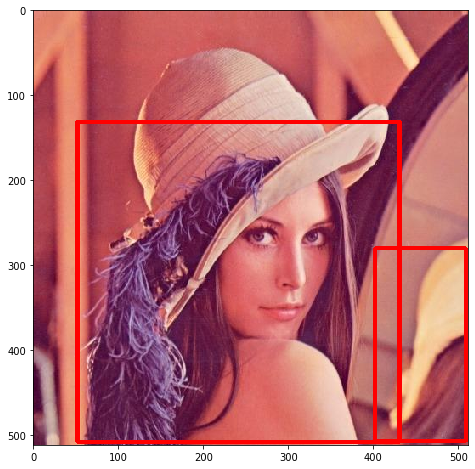

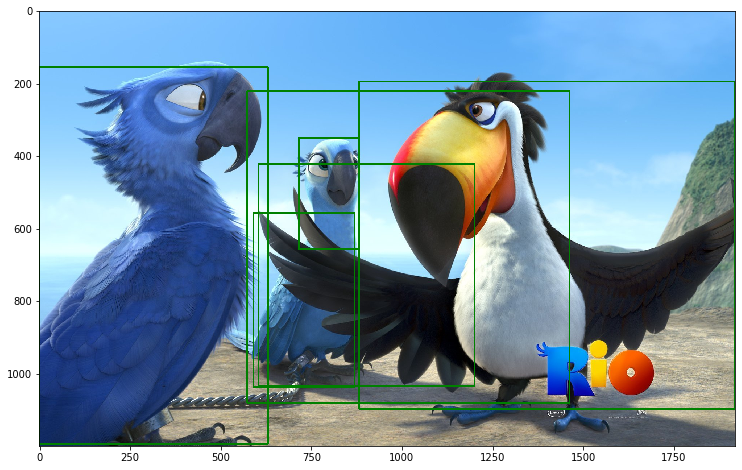

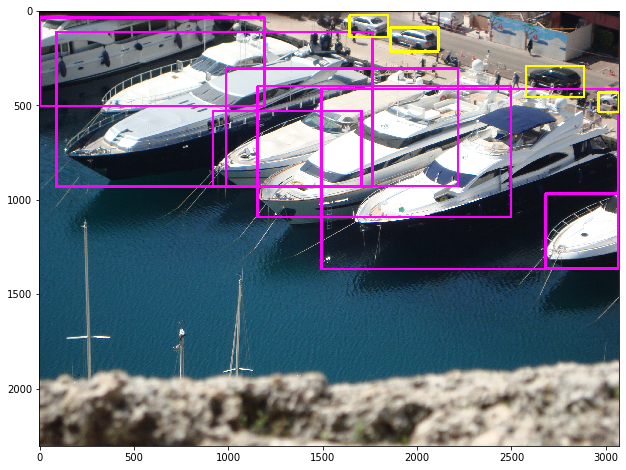

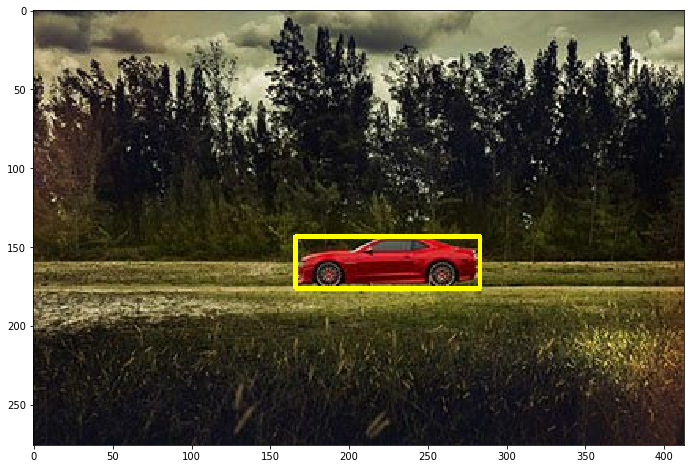

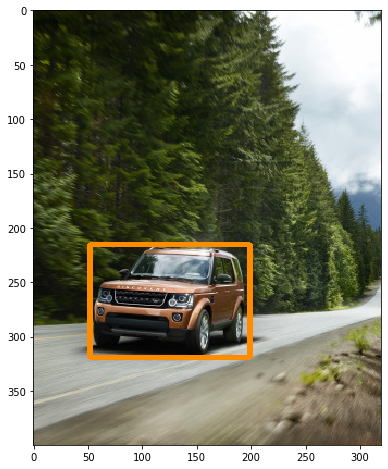

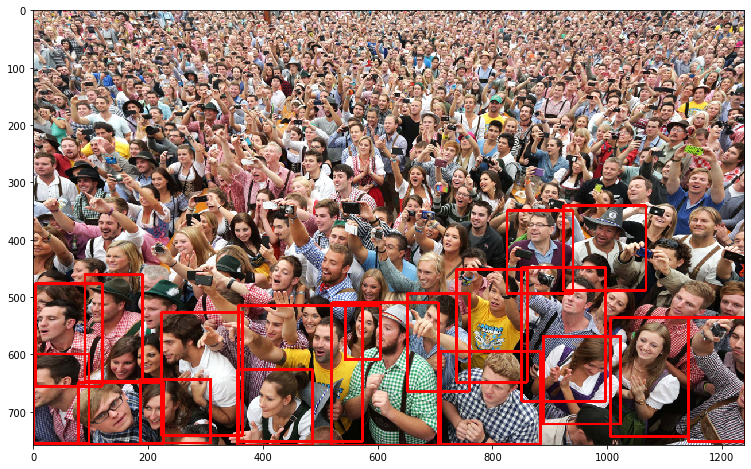

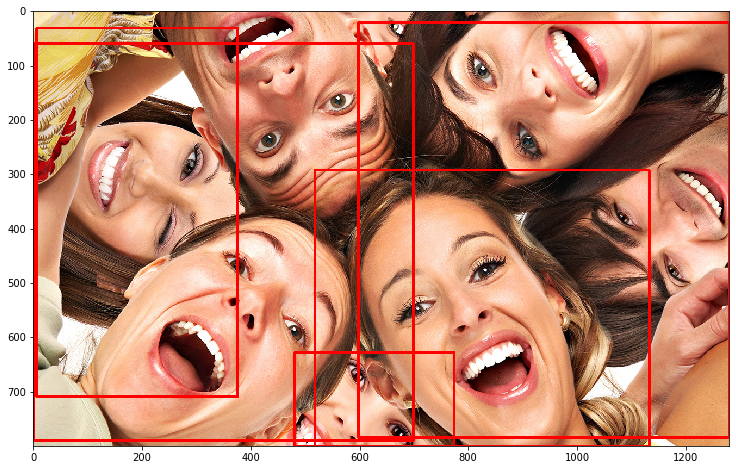

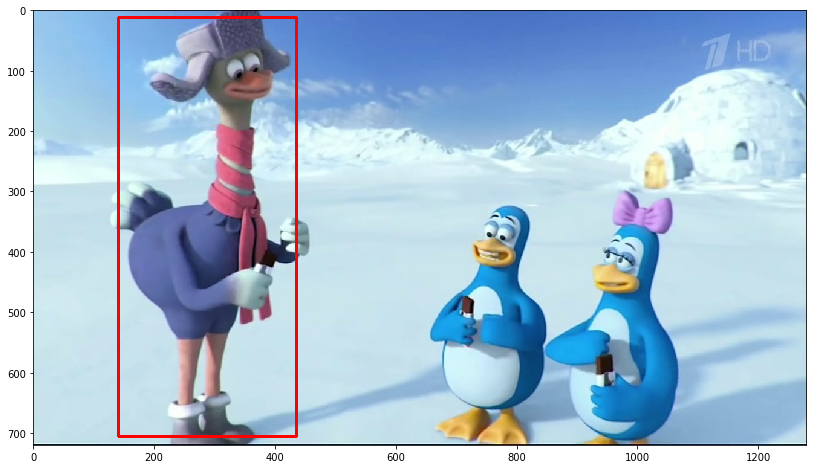

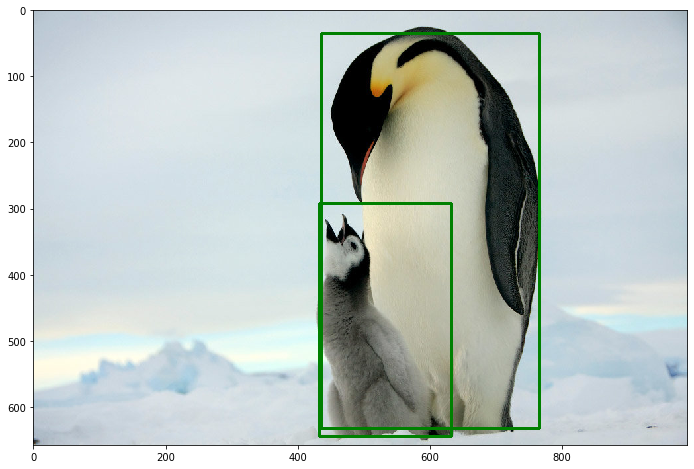

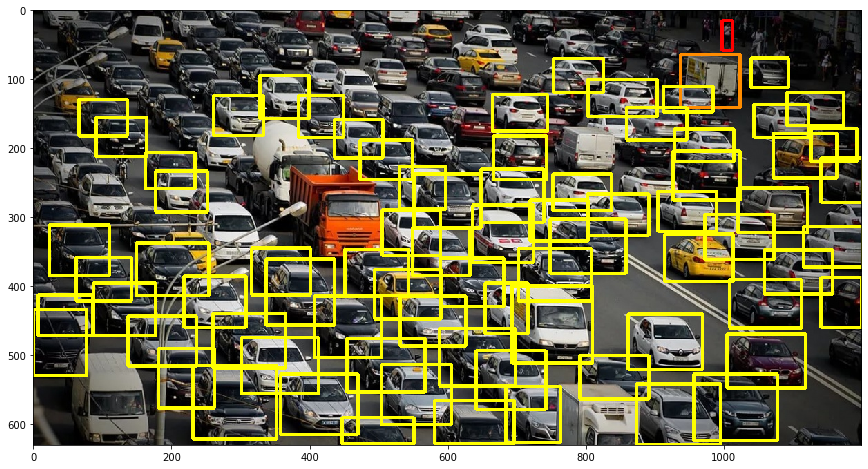

In [0]:
imgs_with_boxes = draw_boxes(np_images, boxes, labels)
for i in range(len(predictions)):
  fig = plt.figure(figsize=(20,8))
  plt.imshow(imgs_with_boxes[i].get().astype('uint'));

Попытаемся проанализировать полученные результаты. На изображениях со скоплениями объектов детектор определяет те из них, которые преимущественно находятся на первом плане. Однако в случае, если объекты расположены плотно друг к другу и фотография сделана под необычным ракурсом, качество результатов детектора может ухудшится. Стоит также отметить некоторые ошибки в классификации: так, машина больших габаритов была определена как грузовик, а страус из рекламы, одетый в шапку, шарф, и куртку, как человек.

# 4.   Предобработка данных

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# распаковываем содержимое датасета, предварительно размещённого на google-диске
!unzip -q /content/gdrive/My\ Drive/Face_DataSet/validation/WIDER_val.zip
!unzip -q /content/gdrive/My\ Drive/Face_DataSet/train/WIDER_train.zip
!unzip -q /content/gdrive/My\ Drive/Face_DataSet/test_set/WIDER_test.zip
!unzip -q /content/gdrive/My\ Drive/Face_DataSet/answers/wider_face_split.zip

In [0]:
# получаем имена изображений
TRAIN_DIR = Path('WIDER_train')
TEST_DIR = Path('WIDER_test/')
VAL_DIR = Path('WIDER_val')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
val_files = sorted(list(VAL_DIR.rglob('*.jpg')))

In [0]:
# устанавливаем постоянные величины
SEED = 42
DATA_MODES = ['train', 'val', 'test']
IMAGE_SIZE = 512
BATCH_SIZE = 1
NUM_CLASSES = 61

In [0]:
# применение аугментаций 
def hard_transforms(img, bbxs):
  if random.random() > 0.4:
    img = F.hflip(img)
    for i, box in enumerate(bbxs):
      box = F.bbox_hflip(box, img.shape[0], img.shape[1])
      bbxs[i] = box
  if random.random() > 0.6:
    angle = random.randint(-30, 30)
    img = F.rotate(img, angle)
    for i, box in enumerate(bbxs):
      box = F.bbox_rotate(box, angle, img.shape[0], img.shape[1], 2)
      bbxs[i] = box
  if random.random() > 0.8:
    alpha = random.uniform(0.5, 1.5)
    beta = random.uniform(-0.2, 0.2)
    img = F.brightness_contrast_adjust(img, alpha, beta)
  return img, bbxs

In [0]:
# класс для подготовки данных
class DataSetCreation(Dataset):
    def __init__(self, im_files, mode):
        super().__init__()
        # список файлов для загрузки
        self.im_files = sorted(im_files)
        # режим работы
        self.mode = mode
        # файл с боксами и метками
        self.answers_dat = scipy.io.loadmat('wider_face_split/wider_face_'+self.mode+'.mat')

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.im_files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # родительские каталоги переданных в функцию файлов
            self.labels = [path.parent.name for path in self.im_files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
 
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.im_files[index])
        # приводим изображение к нужному размеру и к нужному типу
        x = np.array(x)
        if self.mode == 'test':
            x = np.array(x / 255., dtype='float32')
            x = transform(x)
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            # словарь из имён файлов и соответствующих им списков боксов
            answer_dat = {
                'file_lst': self.answers_dat.get('file_list')[label_id[0]][0],
                'bbx_lst': self.answers_dat.get('face_bbx_list')[label_id[0]][0]
            }
            # индекс файла в таблице расширения .mat
            i = np.where(answer_dat.get('file_lst') == str(self.im_files[index]).split('/')[-1].split('.jpg')[0])
            bbxs = answer_dat.get('bbx_lst')[i][0]
            # изначальный вид боксов: [x_left_top, y_left_top, width, height]
            # преобразуем их к виду [x_left_top, y_left_top, x_right_bottom, y_right_bottom] (в последующем [x1, y1, x2, y2])
            bbxs[0:,2:] = bbxs[0:,0:2] + bbxs[0:,2:]
            # преобразуем к виду List[tuple]
            bbxs = [tuple(box) for box in bbxs]            

            if self.mode == 'train':
              # нормализуем боксы (путём деления на ширину и высоту соотвествующих координат)
              bbxs = box_utils.normalize_bboxes(bbxs, x.shape[0], x.shape[1])
              x, bbxs = hard_transforms(x, bbxs)
              # применяем к боксам обратную операцию (умножая на ширину и высоту соответстующие координаты)
              bbxs = box_utils.denormalize_bboxes(bbxs, x.shape[0], x.shape[1])
            
            labels = [label_id.item()] * len(bbxs)
            x = np.array(x / 255., dtype='float32')
            x = transform(x).cuda()
            targets = {'boxes': bbxs,'labels': labels}
            y = []
            y.append(targets)
            return x, y

In [0]:
val_dataset = DataSetCreation(val_files, mode='val')
train_dataset = DataSetCreation(train_files, mode='train')

In [0]:
# функция для демонстрации изображений в датасете
def show_examples(col, row, size, dataset, amount):

  def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

  fig, ax = plt.subplots(nrows=row, ncols=col,figsize=size)
  for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,amount))
    im_val, label = dataset[random_characters]
    label = label[0].get('labels')[0]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                dataset.label_encoder.inverse_transform([label])[0].split('--')[1]))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

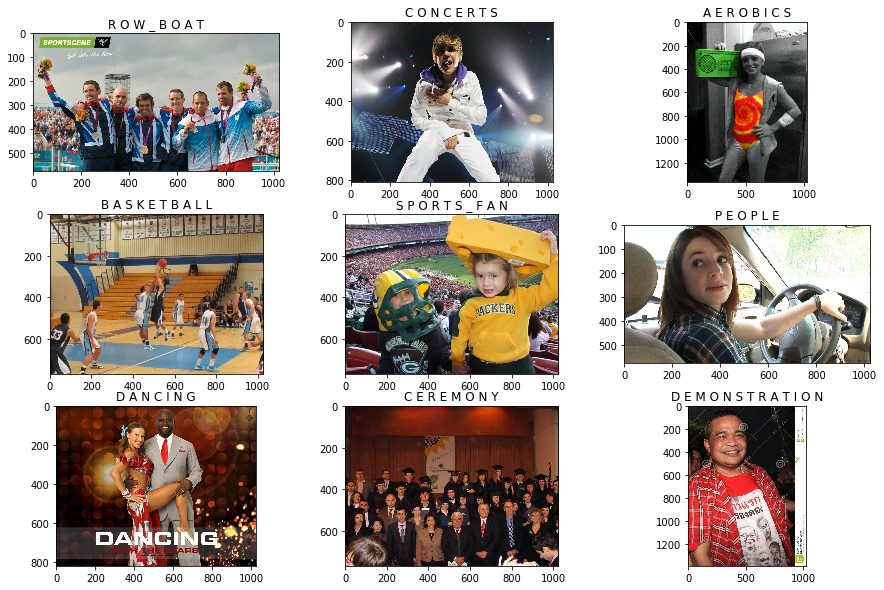

In [0]:
# примеры валидационного датасета
show_examples(3, 3, (15,10), val_dataset, 3000)

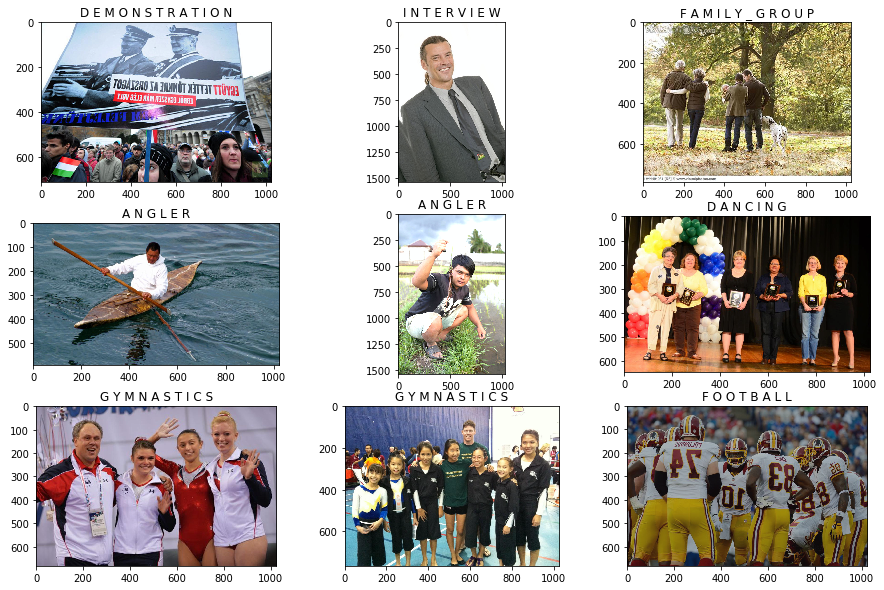

In [0]:
# примеры тренировочного датасета
show_examples(3, 3, (15,10), train_dataset, 12000)

In [0]:
# т.к. в DataLoader не предусмотрены входные данные разной размерности, размер батча устанавливаем 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)# collate_fn=custom_collate, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)# collate_fn=custom_collate, shuffle=False)
torch.cuda.empty_cache()

# 5.  Обучение модели-детектора

In [0]:
for param in model.parameters():
    param.requires_grad = False
# заменяем классифицирующий слой своим
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

In [0]:
def fit_epoch(model, train_loader, optimizer, lr_scheduler, epoch):
  loss_dict_reduced = {
      'loss_classifier':0.0, 
      'loss_box_reg':0.0, 
      'loss_objectness':0.0, 
      'loss_rpn_box_reg':0
  }
  processed_data = 0

  model.train(True).cuda()

  for x, y in train_loader:
    torch.cuda.empty_cache()
    data = x.cuda()
    targets = []
    for i in range(BATCH_SIZE):
      b = []
      c = []
      for j, box in enumerate(y[i].get('boxes')):
        # боксы размеров менее 20*20 слишком маленькие, и loss принимает значения nan
        if not ((box[2].item() - box[0].item() < 20) and (box[3].item() - box[1].item() < 20)):
          b.append(torch.stack(box))
          c.append(y[i].get('labels')[j])
      for j in range(len(b)):
        b[j] = [b[j][0].item()] + [b[j][1].item()] + [b[j][2].item()] + [b[j][3].item()] 
      labels = []
      for j in range(len(c)):
        labels = labels + [c[j].item()]
      b = torch.tensor(b, dtype=torch.float32)
      labels = torch.tensor(c)
      # targets.append({'boxes': b, 'labels': labels})
      targets.append({'boxes': b.cuda(), 'labels': labels.cuda()})
      torch.cuda.empty_cache()
        
    if not c:
      continue

    try:
      loss_dict = model(data, targets)
    except:
      torch.cuda.empty_cache()
      break
    torch.cuda.empty_cache()

    losses = sum(loss for loss in loss_dict.values())

    for key in loss_dict.keys():
        loss_dict_reduced.update([(
            key, 
            loss_dict_reduced.get(key) + loss_dict.get(key) * x.size(0)
        )])
    processed_data += x.size(0)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    lr_scheduler.step()
    torch.cuda.empty_cache()
  
  loss_values = sum(loss / processed_data for loss in loss_dict_reduced.values())
  train_loss = loss_values.item()
  torch.cuda.empty_cache()

  return train_loss

In [0]:
def eval_epoch(model, val_loader, best_loss, epoch, model_name='prj_detection_model'):
  loss_dict_reduced = {
      'loss_classifier':0.0, 
      'loss_box_reg':0.0, 
      'loss_objectness':0.0, 
      'loss_rpn_box_reg':0
  }
  processed_data = 0

  model.train(True).cuda()

  for x, y in val_loader:
    torch.cuda.empty_cache()
    data = x.cuda()
    targets = []
    for i in range(BATCH_SIZE):
      b = []
      c = []
      for j, box in enumerate(y[i].get('boxes')):
        if not ((box[2].item() - box[0].item() < 20) and (box[3].item() - box[1].item() < 20)):
          b.append(torch.stack(box))
          c.append(y[i].get('labels')[j])
      for j in range(len(b)):
        b[j] = [b[j][0].item()] + [b[j][1].item()] + [b[j][2].item()] + [b[j][3].item()] 
      labels = []
      for j in range(len(c)):
        labels = labels + [c[j].item()]
      b = torch.tensor(b, dtype=torch.float32)
      labels = torch.tensor(c)
      # targets.append({'boxes': b, 'labels': labels})
      targets.append({'boxes': b.cuda(), 'labels': labels.cuda()})
      torch.cuda.empty_cache()
    
    if not c:
      continue
  
    with torch.no_grad():
      # loss_dict = model(x, targets)
      loss_dict = model(data, targets)
      losses = sum(loss for loss in loss_dict.values())
      for key in loss_dict.keys():
        loss_dict_reduced.update([(
            key, 
            loss_dict_reduced.get(key) + loss_dict.get(key) * x.size(0)
        )])
      processed_data += x.size(0)
      torch.cuda.empty_cache()

  loss_values = sum(loss / processed_data for loss in loss_dict_reduced.values())
  val_loss = loss_values.item()
  torch.cuda.empty_cache()

  # сохраняем лучшую модель
  if val_loss < best_loss:
    state = {
        'net': model.state_dict(),
        'loss': val_loss,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))
  return val_loss

In [0]:
def train(model, train_loader, val_loader, epochs):
  history = []
  best_loss = 100
  log_template = "\nEpoch {ep:04d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f}"

  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    # объявляем политику изменения гиперпараметров
    params = [p for p in model.parameters() if p.requires_grad]
    opt = torch.optim.SGD(params, lr=0.000001,
                                momentum=0.9, weight_decay=0.0000005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                                   step_size=3,
                                                   gamma=0.1)

    # итерируемся по эпохам
    for epoch in range(epochs):
      torch.cuda.empty_cache()
      train_loss = fit_epoch(model, train_loader, opt, lr_scheduler, epoch)
      print("loss", train_loss)
      torch.cuda.empty_cache()
      val_loss = eval_epoch(model, val_loader, best_loss, epoch)
      torch.cuda.empty_cache()

      lr_scheduler.step()
      history.append((train_loss, val_loss))
      best_loss = max(best_loss, val_loss)

      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                     v_loss=val_loss))
  return history

In [0]:
history = train(model, train_loader, val_loader, epochs=4)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
train_loss, val_loss = zip(*history)

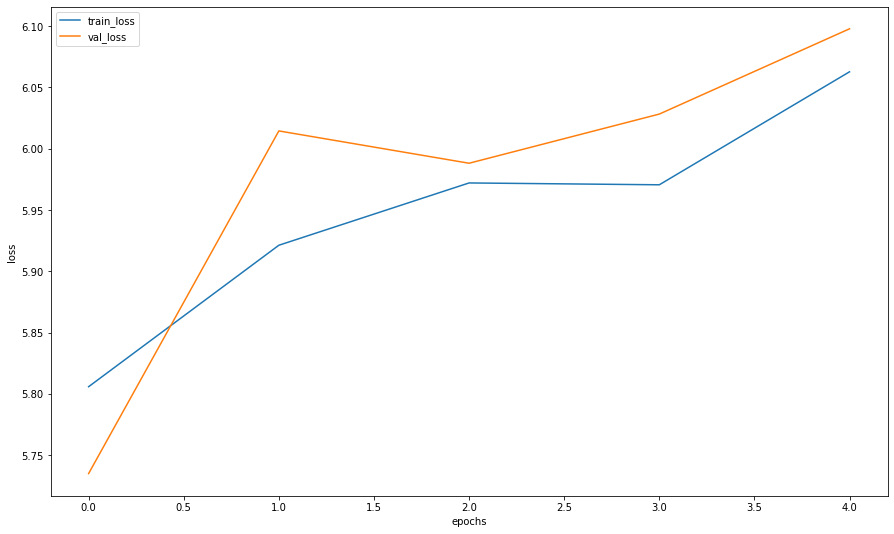

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# 6.  Измерение качества работы модели

In [0]:
class Metrics():
  def __init__(self, model, dataset):
    super().__init__()
    self.model = model
    self.dataset = dataset
    
  # функция вычисляет индекс Джакарда
  # входные данные: pred_bbx, true_bbx --- координаты этих боксов в виде 
  # [x1, y1, x2, y2]
  def JaccardIndex(self, pred_bbx, true_bbx):

    # функция вычисляет площадь пересечения предсказанного и истинного боксов
    def intersection_area(pred_bbx, true_bbx):
      max_left_x = max(pred_bbx[0], true_bbx[0])
      max_left_y = max(pred_bbx[1], true_bbx[1])
      min_right_x = min(pred_bbx[2], true_bbx[2])
      min_right_y = min(pred_bbx[3], true_bbx[3])
      width = max_left_x - min_right_x
      height = max_left_y - min_right_y
      if width * height < 0:
        intersect_area = 0
      else:
        intersect_area = width * height
      return intersect_area 

    # функция вычисляет площадь объединения предсказанного и истинного боксов
    def union_area(pred_bbx, true_bbx):
      width_p = np.abs(pred_bbx[0] - pred_bbx[2])
      width_t = np.abs(true_bbx[0] - true_bbx[2])
      height_p = np.abs(pred_bbx[1] - pred_bbx[3])
      height_t = np.abs(true_bbx[1] - true_bbx[3])
      area_p = width_p * height_p
      area_t = width_t * height_t
      i_area = intersection_area(pred_bbx, true_bbx)
      return area_p + area_t - i_area

    intersect_area = intersection_area(pred_bbx, true_bbx)
    total_area = union_area(pred_bbx, true_bbx)
    return intersect_area / total_area
  
  # функция подготавливает данные: из данных вида
  # [{'boxes':tensor([[],[],..]), 'labels':tensor([]), 'scores':tensor([])}, {},..]
  # получает данные вида [[[боксы картинки 0 класса 0], [боксы картинки 1 класса 0],..], [[боксы картинки 0 класса1],..],..]
  def prepare_data(self, data):
    prepared_boxes = []
    for i in range(NUM_CLASSES):                    # итерируемся по классам
      class_boxes = []
      for j in range(len(data)):                    # итерируемся по картинкам
        pict_boxes = []
        for k in range(len(data[j].get('labels'))):   # итерируемся по меткам
          if data[j].get('labels')[k] == i:
            pict_boxes.append(data[j].get('boxes')[k])
        class_boxes.append(pict_boxes)
      prepared_boxes.append(class_boxes)
    return prepared_boxes
  
  def create_table(self):
    self.model.eval()# .cuda()
    pred_data = []
    true_data = []
    # собираем предсказания и истинные данные
    for x, y in self.dataset:
      torch.cuda.empty_cache()
      data = x.cuda()
      pred_data.append(model(data)[0])
      b = []
      c = []
      for j, box in enumerate(y[0].get('boxes')):
        b.append(torch.stack(box))
        c.append(y[0].get('labels')[j])
      for j in range(len(b)):
        b[j] = [b[j][0].item()] + [b[j][1].item()] + [b[j][2].item()] + [b[j][3].item()] 
      labels = []
      for j in range(len(c)):
        labels = labels + [c[j].item()]
      b = torch.tensor(b, dtype=torch.float32)
      labels = torch.tensor(c)
      true_data.append({'boxes': b, 'labels': labels})
      # true_data.append({'boxes': b.cuda(), 'labels': labels.cuda()})

    # составляем таблицу поклассовых precision и recall
    predictions = self.prepare_data(pred_data)
    true_boxes = self.prepare_data(true_data)
    # список поклассовых precision и recall
    precision = []
    recall = []
    for i, cls in enumerate(predictions):       # итерируемся по классам
      tp_amount = 0               # количество true-positive для одного класса
      fp_amount = 0               # количество false-positive -//-
      fn_amount = 0               # количество false-negative -//-
      for j, pred in enumerate(cls):            # итерируемся по картинкам
        TP = [0] * len(pred)
        FP = [0] * len(pred)
        # список индексов боксов, уже определённых как true-positive
        idxs_seen = []
        for k, box_p in enumerate(pred):        # итерируемся по боксам
          if k in idxs_seen:
            continue
          maxIoU = 0
          kmax = -1
          for box_t in true_boxes[i][j]:
            IoU = self.JaccardIndex(box_p.detach().numpy(), box_t.detach().numpy())
            if IoU > maxIoU:
              maxIoU = IoU
              kmax = k
          if maxIoU > 0.5:
            TP[k] = 1
            idxs_seen.append(kmax)
          else:
            FP[k] = 1
        
      tp_amount += sum(TP)
      fp_amount += sum(FP)
      fn_amount += len(true_boxes[i][j]) - tp_amount
      precision.append(tp_amount / (tp_amount + fp_amount + 1e-4))
      recall.append(tp_amount / (tp_amount + fn_amount + 1e-4))
    labels = list(range(61))
    metrics_table = pd.DataFrame({'Class': labels, 'Precision': precision, 'Recall': recall})   

    return metrics_table

In [0]:
checkpoint = torch.load('./checkpoint/ckpt_{}.pth'.format('prj_detection_model'))
model.load_state_dict(checkpoint['net'])

prec_and_rec = Metrics(model = model, dataset = val_loader)

In [0]:
# создаём таблицу поклассовых Precision и Recall на Google-диске
table = prec_and_rec.create_table()
table.to_csv('gdrive/My Drive/Face_DataSet/precision_and_recall.csv', index=False)

In [0]:
table.head()

# Выводы
Результаты созданной модели далеки от желаемых, поэтому ещё предстоит найти оптимальные гиперпараметры и количество эпох. Тем не менее, в процессе работы удалось познакомиться с моделью-детектором Faster R-CNN, научиться применять её на выбранных изображениях, осуществлять подготовку данных, в том числе и использовать библиотеку albumentations для аугментаций. Также были написаны функции для вычисления индекса Джакарда и вычисления поклассовых Precision и Recall.